# Chianson Siu
# Wei Liao
# CSE160: Final Project

### Interpersonal StackExchange Data Analysis

This script analyzes the data about questions and users from StackExchange's (Interpersonal Skills)[https://interpersonal.stackexchange.com/] branch. It seeks to answer the following 3 research questions: 
1. **What type of questions are more likely to have an answer?** 
    * Given a post has an accepted answer, we hypothesize that either longer posts or posts about relationships will most likely have an accepted answer. This may be because longer posts have spent more time detailing their question, so other users are able to clearly understand what they are asking whereas as short post may leave out key details. Additionally, a post about a relationship, such as boyfriend or girlfriend, may likely have an answer because it is old and extremely common topic. Therefore, more people are likely to have experience or knowledge about relationship issues, allowing for a greater chance of receiving an answer.

2. **What type of users have high reputation scores?**
    * Given an equal number of approved responses between users, we hypothesize that users with longer answers will have higher reputation scores. This may be because a longer answer requires more effort and as a result is more thought out. If it completely answers the question, then it is more likely to be upvoted for other users, giving the answerer more points than just the 15 points given for an accepted answer.

3. **What type of users have low reputation scores?**
     * We hypothesize that users who react more negatively towards others’ posts, will be overrepresented among users with low reputation scores. This is because users that react negatively towards others’ posts have a higher chance of leaving negative remarks. A post marked as abusive by 6 or more other users results in a loss of 100 points, the largest reputation loss possible influenced by other users (a user can lose more points if they offer over 100 points as bounty for one of their questions). 

#### Motivation and Background

These research questions are worth investigating because it can be used as proxy to discover what types of interpersonal issues were prevalent in 2018, while also informing people about the user base of Interpersonal Skills website. Understanding prevalent social topics is useful for understanding how society may be influencing the social culture over the years. This may be of interest to psychologist or mental health organizations, where the researchers in the organizations may need to understand contemporary problems to provide meaningful and effective solutions. Additionally, Interpersonal Skills is only 1 of 173 online communities under Stack Exchange. Therefore, the company may be interested in this analysis because it will inform them more about their users, which could lead to future decisions on how to improve their websites. This could range from simple aesthetics to more functional changes like adding or removing privileges based on knowing what types of users have high reputation scores.

### Dataset
Our group used the Interpersonal Skills data dump from the Stack Exchange,
Inc. archive. It can be downloaded here: https://archive.org/download/stackexchange.
• interpersonal.meta.stackexchange.com.7z – 20.9 MB
• interpersonal.stackexchange.com.7z – 138 MB
Each site on Stack Exachange comes with two data files; the site’s data, and the sites metadata.
Both of which are stored as XML files. Each zip contains 8 XML files: badges, comments, post
history, post links, posts, tags, users, and votes.

### Methodology

1. For the first research question, the study analyzed the tags, post body, title, and length of post. We separated posts into two types: posts that have an accepted answer and posts that do not have an accepted answer. We used text analysis techniques to compare the top reoccurring words in the tags, post body, and title of the two types of posts. Then we also compared the average length of the two types of posts. Finally, we observed trends that showed up in the resulting graphs.
	
2. For the second research question, the study analyzed the relationship between a user’s reputation score and the average post body length with the number of answers as a control variable. We went through the data and extracted the needed information. Then we separated the resulting data tables into groups that have the same number of answers. Lastly, we used Pearson correlation analysis technique to see if the user’s reputation score increases as the average post body length increases.
	
3. For the third research question, the study analyzed the relationship between a user’s reputation score and the ratio of upvotes to downvotes that the user has given to others’ posts. We first combed through the data sets to extract the user ID and the corresponding reputation score, upvotes, and downvotes. Then we computed the upvote to downvote ratios for each user. Finally, we conducted Pearson correlation analysis to the resulting data to see whether the user’s reputation score has a positive correlation with the upvote to downvote ratio.


### Script
The following the python script used for this project:

In [2]:
# needed in order to reference the stop words in the NLTK library
nltk.download('stopwords')

In [57]:
#-------------------------------------------------------------------------------
# Name:        StackExchange Interpersonal Skills Analysis
# Purpose:     Understand the questions that users post on the website and what
#              contributes to high and low reputation scores.
#
# Author:      Chianson Siu, Wei Liao
#
# Created:     13/02/2019
#-------------------------------------------------------------------------------
import nltk
from nltk.corpus import stopwords
from collections import Counter
from scipy.stats.stats import pearsonr
import pandas as pd
import operator
import matplotlib.pyplot as plt
import numpy as np


def removeBodyXMLTags(df):
    '''
    This function removes all XML tags in the "Body" column of the pandas data
    frame, e.g, all <p> and </p> tags should be removed.
    @param df is a pandas dataframe with one column that refers to the
              body of the text named "Body"
    @return a pandas datafame    
    '''

    # For each post in column "Body" of the panda dataframe
    # Remove all XML tags and put the result back to the
    # corresponding cell
    for i in range(len(df.index)):
        # Obtain cell content to edit
        postBody = df.at[i, "Body"]

        # Remove XML flasg and put result back to corresponding column
        df.at[i, "Body"] = removeXMLTags(str(postBody))
    return df


def removeXMLTags(text):
    '''
    Given a string of content, remove all occurences of XML tags.
    (XML tags is anything that starts with '<' and ends with '>')

    @param text String. A string of text.

    @return a String with all occurences of XML tags removed
    '''

    textList = list(text)
    # Remove All the XML tags
    j = 0
    while j < len(textList):
        if textList[j] == "<":
            while textList[j] != ">":
                textList.pop(j)
            textList.pop(j)
        else:
            j += 1

    # Convert list back into string and return the result
    return ''.join(textList)



def wordToCount(text):
    '''
    Given a string of content, count the number of occurence of each word,
    then returns the result.
    
    @param text String. A string of text.

    @return a dictionary mapping word to word count
    '''
    wordDict = dict()
    textList = str(text).split(" ")
    for word in textList:
        key = word.lower()
        if key != " " and key != "":
            wordDict[key] = wordDict.get(key, 0) + 1
    return wordDict


def top10Words(wordDict):
    '''
    Given a dictionary that maps word to its occurence count, return a
    list of top 10 highest occuring words

    @param wordDict Dictionary. A dictionary that maps a word to the 
                    number of times that it occured in a text

    @return a list of top 10 highest occuring words
    '''
    
    # Create list of words to exclude from final list
    exclude = set(stopwords.words('english'))
    additionalStopWords = {"would", "want", "get", "make", "know",
                           "ask", "something", "may", "without", 
                           "stop", "one", "really", "someone",
                           "could", "need", "might", "me?", "i'm",
                           "even", "also", "way", "things", "tell",
                           "think", "feel", "say", "-", "like",
                           "need", "best", "talk", "deal", "asking",
                           "handle", "talking", "nan", "good", "go"}
    
    # Add in additional words not contained in the NLK library
    exclude = exclude.union(additionalStopWords)
    
    result = list()
    # Sort dictionary into tuples according to value
    # Creates a list of tuples (word, count) sorted from highest count
    # to lowest count
    sorted_words = sorted(wordDict.items(), key=operator.itemgetter(1),
        reverse=True)

    # Take only the top 10 word part of the sorted_words
    # Exclude the common non-meaning words such as "the",
    # "of", "or"
    for i in range(100):
        # Make sure i is not over the range of sorted_words
        # and result has 10 words
        if i >= len(sorted_words) or len(result) == 10:
            break

        # Append words that are not in the exclude list
        if sorted_words[i][0] not in exclude:
            result.append(sorted_words[i])
    return result


def filter10User(users_df):
    '''
    Takes a user data frame. Filters out the first 10 users and store the
    results in a dictionary with key being the user ID and the value being
    the user's reputation score

    @param users_df Pandas datagrame. The datafram that contains information
                    on users.

    @return a dictionary of the first 10 users (key is user ID, value is
            reputation)
    ''' 
    result = dict()
    for i in range(10):
        # Make user dataframe has at least 10 entries
        if len(users_df.index) > 10:
            # Take the first 10 Id and Reputation out
            section = users_df.head(n=10)[["_Id", "_Reputation"]]
            # Store ID as key and Reputation as value
            result[section.iloc[i, 0]] = section.iloc[i, 1]
    return result


def numWords(text):
    '''
    Count the number of words there is in a block of string
    '''
    textList = text.split(" ")
    return len(textList)


def tagCount(text):
    textList = list(str(text))
    # take the words between the "<>"
    wordString = ""
    j = 0
    while j < len(textList):
        if textList[j] == "<":
            # pop out the first "<"
            textList.pop(j)
            while textList[j] != ">":
                wordString += textList.pop(j)
            textList.pop(j)
            wordString += " "
        else:
            j += 1

    tag_dict = wordToCount(wordString)
    return tag_dict

### Q1 Data Wrangling Function

In [52]:
def q1(posts_df):
    '''
    Performs tasks necessary to solve research question 1
    
    @param posts_df is a DataFrame of post data
    
    @returns dictionary of word counts for posts with and without answers
    '''

    # Create variables
    ans_tag = dict()
    ans_body = dict()
    ans_title = dict()
    ans_len = 0
    ans_count = 0
    
    noAns_tag = dict()
    noAns_body = dict()
    noAns_title = dict()
    noAns_len = 0
    noAns_count = 0

    # Fill in PostID, Length, AnswerCount of each row
    for i in range(len(posts_df.index)):
        body = posts_df.at[i, "Body"]

        # Obain each column info
        tags = tagCount(posts_df.at[i, "Tags"])
        top10Body = wordToCount(body)
        length = numWords(str(body))
        title = wordToCount(posts_df.at[i, "Title"])

        # Add a new row in the ans or no_ans dataframe with the correct values
        if pd.isnull(posts_df.loc[i, "AcceptedAnswerId"]):
            # There is no accepted answer
            noAns_tag = Counter(noAns_tag) + Counter(tags)
            noAns_body = Counter(noAns_body) + Counter(top10Body)
            noAns_title = Counter(noAns_title) + Counter(title)
            noAns_len += length
            noAns_count += 1
        else:
            ans_tag = Counter(ans_tag) + Counter(tags)
            ans_body = Counter(ans_body) + Counter(top10Body)
            ans_title = Counter(ans_title) + Counter(title)
            ans_len += length
            ans_count += 1
       
    results = dict()
    
    results["No Ans - Tags"] = top10Words(noAns_tag)
    results["No Ans - Body"] = top10Words(noAns_body)
    results["No Ans - Title"] = top10Words(noAns_title)
    results["noAns_avg_len"] = int((noAns_len/noAns_count))

    
    results["Ans - Tags"] = top10Words(ans_tag)
    results["Ans - Body"] = top10Words(ans_body)
    results["Ans - Title"] = top10Words(ans_title)
    results["ans_avg_len"] = int((ans_len/ans_count))
    
    return results

#### Q2 Data Wrangling Function

In [5]:
def q2(posts_df, users_df):
    '''
    Performs tasks necessary to solve research question 2
    
    @param posts_df is a DataFrame of post data
    @param users_df is a DataFrame of user data
    
    @returns a Pandas DataFrame with "UserID", "Reputation", "AnswerCount", and
             "AverageBodyLength"
    '''
    q2_df = pd.DataFrame(columns=("UserID", "Reputation", "AnswerCount", 
        "AverageBodyLength"))

    # Get UserID and Reputation first
    q2_df.loc[ : , "UserID"] = users_df.loc[ : , "_Id"]
    q2_df.loc[ : , "Reputation"] = users_df.loc[ : , "_Reputation"]

    # id to length and count dictionary
    id_lenCount = dict()

    # Find which posts are answers
    ans_set = set()
    for i in range(len(posts_df.index)):
        # this post is an answer
        if int(posts_df.at[i, "PostTypeId"]) == 2:
            ans_set.add(posts_df.at[i, "Id"])

    # Fill in answer count and accumulate body length for now
    for i in range(len(posts_df.index)):
        userID = posts_df.at[i, "OwnerUserId"]
        # add only if userID exist and if the post is an answer
        if userID in q2_df.loc[ : , "UserID"] and posts_df.at[i, "Id"] in ans_set:
            if userID not in id_lenCount.keys():
                # list first element is count, second is accumulated body len
                id_lenCount[userID] = list()
                id_lenCount[userID].append(0)
                id_lenCount[userID].append(numWords(str(posts_df.at[i, "Body"])))
            else:
                id_lenCount[userID][0] += 1
                id_lenCount[userID][1] += numWords(str(posts_df.at[i, "Body"]))

    # Now fill average length and answer count back into the main table
    for i in range(len(q2_df.index)):
        userID = q2_df.at[i, "UserID"]
        if userID in id_lenCount.keys():
            answerCount = id_lenCount[userID][0]
            q2_df.at[i, "AnswerCount"] = answerCount
            if answerCount != 0: # int conversion rounds down because only want whole word
                q2_df.at[i, "AverageBodyLength"] = int(id_lenCount[userID][1]/answerCount)

    q2_df = q2_df.dropna()
    
    # q2_df.to_excel("Q2_Result.xlsx")
    return q2_df

#### Q3 Data Wrangling Function

In [6]:
def q3(users_df):
    '''
    Performs tasks necessary to solve research question 3
    
    @param users_df is a DataFrame of user data
    
    @returns a Pandas dataframe with "UserID", "Reputation", "UpVotes"
             "DownVotes", and  "RatioUpToDown"
    '''
    q3_df = pd.DataFrame(columns=("UserID", "Reputation", "UpVotes",
        "DownVotes"))

    # extract the userID, reputation, upvotes, and downvotes
    q3_df.loc[ : , "UserID"] = users_df.loc[ : , "_Id"]
    q3_df.loc[ : , "Reputation"] = users_df.loc[ : , "_Reputation"]
    q3_df.loc[ : , "UpVotes"] = users_df.loc[ : , "_UpVotes"]
    q3_df.loc[ : , "DownVotes"] = users_df.loc[ : , "_DownVotes"]
    
    
    # remove rows with any zeros
    q3_df = q3_df[(q3_df != 0).all(1)]
    
    q3_df["RatioUpToDown"] = q3_df["UpVotes"] / q3_df["DownVotes"]
    #print(q3_df)
    #q3_df.to_excel("Q3_Result.xlsx")
    return q3_df

In [7]:
# read in the CSV file to pandas dataframe. The CSV file must be coded as
# UTF-8.
posts_df = pd.read_csv("Posts2018.csv")
posts_df = removeBodyXMLTags(posts_df)

In [8]:
users_df = pd.read_csv("Users.csv")

#### Retrieving Results

In [58]:
# Research Question 1 results
q1_result_dict = q1(posts_df)
q1_result_dict

{'No Ans - Tags': [('conversations', 52),
  ('relationships', 37),
  ('united-states', 31),
  ('friends', 30),
  ('work-environment', 23),
  ('conflict-aversion', 22),
  ('awkward-situations', 20),
  ('difficult-people', 14),
  ('politeness', 14),
  ('family', 14)],
 'No Ans - Body': [('people', 2664),
  ('time', 2097),
  ('person', 1405),
  ('try', 1234)],
 'No Ans - Title': [('friend', 21),
  ('people', 16),
  ('politely', 14),
  ('communicate', 10),
  ('respond', 10),
  ('friends', 7),
  ('help', 6),
  ('conversation', 6),
  ('close', 6),
  ('person', 6)],
 'noAns_avg_len': 289,
 'Ans - Tags': [('conversations', 71),
  ('friends', 69),
  ('relationships', 55),
  ('conflict-aversion', 40),
  ('united-states', 40),
  ('awkward-situations', 34),
  ('politeness', 31),
  ('work-environment', 29),
  ('family', 29),
  ('conflicts', 22)],
 'Ans - Body': [('time', 279),
  ('people', 204),
  ('friends', 170),
  ('friend', 163)],
 'Ans - Title': [('friend', 36),
  ('politely', 18),
  ('convinc

In [10]:
# Research Question 2 results
q2_result_df = q2(posts_df, users_df)
q2_result_df

,UserID,Reputation,AnswerCount,AverageBodyLength
18,18,5603,3,380
29,29,6652,14,229
36,36,12493,8,607
57,59,48108,43,285
59,61,28799,17,406
63,65,2326,3,245
72,75,1941,3,495
75,78,196,1,289
85,88,2296,3,447
94,98,2819,3,166


In [11]:
# Research Question 3
q3_result_df = q3(users_df)
q3_result_df

,UserID,Reputation,UpVotes,DownVotes,RatioUpToDown
0,-1,1,2231,4082,0.546546
3,3,90,10,81,0.123457
7,7,96,11,8,1.375000
10,10,434,26,3,8.666667
12,12,872,8,1,8.000000
13,13,446,58,5,11.600000
16,16,942,99,165,0.600000
17,17,2566,25,5,5.000000
18,18,5603,72,52,1.384615
19,19,1144,19,40,0.475000


#### Q1 Result Plot Creation

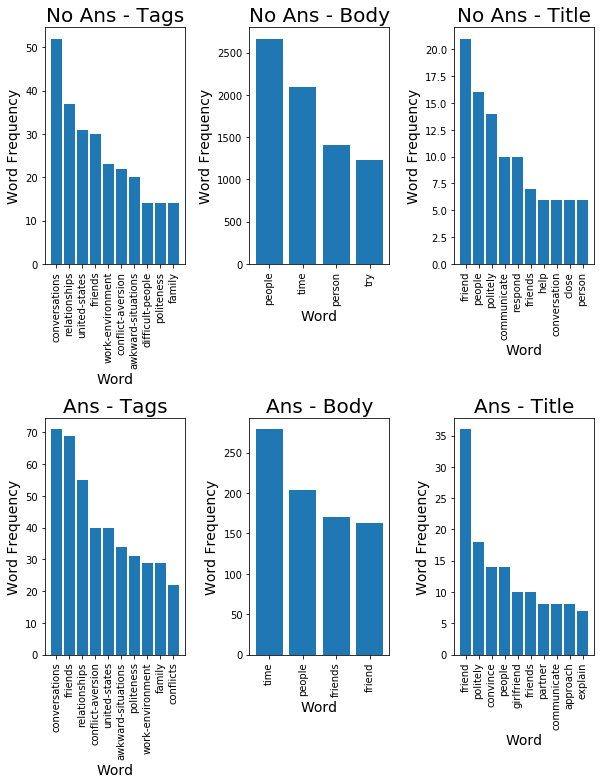

In [87]:
fig3 = plt.figure(figsize = (8.5, 11))

index = 1
                  
for key in q1_result_dict.keys():
    
    if("avg_len" not in key):
        next_df = pd.DataFrame(q1_result_dict[key], columns = ["Word", "Count"])
        
        xAxis = next_df["Word"].values
        yAxis = next_df["Count"].values
        
        ax = fig3.add_subplot(2, 3, index)
        
        index += 1
        
        ax.bar(xAxis, yAxis)

        xTicks = ax.get_xticklabels()
        
        for tick in xTicks:
            tick.set_rotation(90)
        
        ax.set_xlabel("Word", fontsize = 14)
        ax.set_ylabel("Word Frequency", fontsize = 14)
        ax.set_title(key, fontsize = 20)

fig3.tight_layout()
fig3.savefig("figures/q1_bar_charts.png")
fig3.savefig("figures/q1_bar_charts_.pdf")

#### Q2 Plot Creation

Avg correlation: 0.18224
Avg P-Value: 0.29891


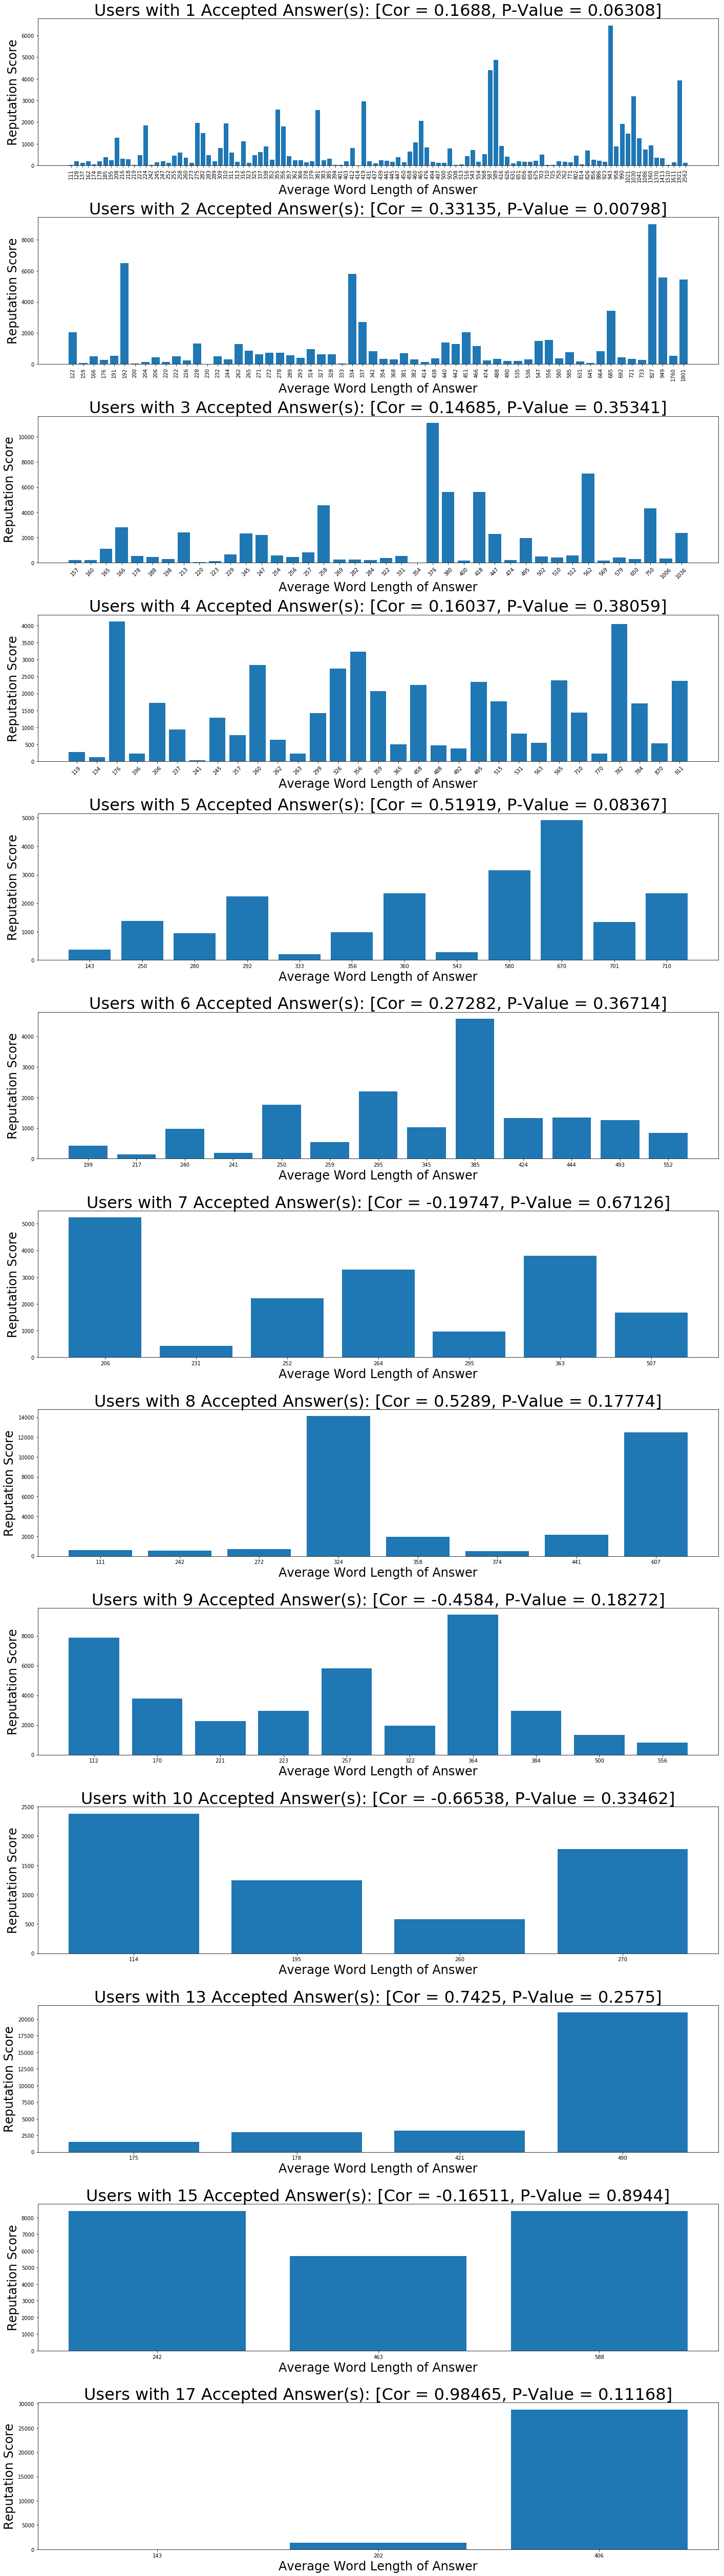

In [86]:
# get all variations of answer counts
# this represents number of questions answered
allAnswerCounts = set(q2_result_df["AnswerCount"])

# create matplot figure with initial size 80 x 5
# width is much greater than height because 
# each bar chart will have many categories
height = 5
fig = plt.figure(figsize = (8.5, height))

pearsonResult = dict()
pearsonResult["correlation"] = list()
pearsonResult["p-value"] = list()

# counter for position the graph
index = 1
for answerCount in allAnswerCounts:
    # boolean filter array for the answerCount
    ansFilter = q2_result_df['AnswerCount'] == answerCount

    # user filter results to make a bar chart
    eachAnswerCount = q2_result_df[ansFilter]

    if(len(eachAnswerCount.index) > 2):
        #sort the new table by AverageBodyLength ascending
        eachAnswerCount = eachAnswerCount.sort_values(by=['AverageBodyLength'])

        # convert panda to array because matplot expects an array
        # arrayToGraph = eachAnswerCount.values

        # x-axis = avg length (low to high) 
        # convert to string to allow matplot to recognize it as category
        xAxis = eachAnswerCount['AverageBodyLength'].astype(str).values
        
        # y-axis = reputation points
        values = eachAnswerCount['Reputation'].values
        
        # increment default defaultHeight for next interation
        height += 5
        
        # increase figure height to accomodate new graph
        fig.set_size_inches(20, height)
        
        # add new blank subplot to the figure
        #13 x 1 because there are 13 plots
        ax = fig.add_subplot(13, 1, index)
        
        # add axes (the bars) to the subplot
        ax.bar(xAxis, values)
        
        # calculate pearson
        pearsScore = pearsonr(eachAnswerCount['AverageBodyLength'].values, values)
        
        # update dictionary        
        pearsonResult.get("correlation").append(pearsScore[0])
        pearsonResult.get("p-value").append(pearsScore[1])
        
        # get x axis labels
        xTicks = ax.get_xticklabels()
        
       
        # rotate the x-axis tick values
        for tick in xTicks:
            if(len(xTicks) > 40):
                tick.set_rotation(90)
            elif(len(xTicks) > 15):
                tick.set_rotation(45)
        ax.set_xlabel("Average Word Length of Answer", fontsize = 24)
        ax.set_ylabel("Reputation Score", fontsize = 24)
        ax.set_title("Users with " + str(answerCount) + " Accepted Answer(s): [Cor = " 
                     + str(round(pearsScore[0], 5))
                     + ", P-Value = "
                     + str(round(pearsScore[1], 5)) + "]", 
                     fontsize = 32)

        index += 1 #increment position for next graph

fig.tight_layout()
fig.savefig("figures/q2_bar_charts.png")
fig.savefig("figures/q2_bar_charts_.pdf")

print("Avg correlation:", round(sum(pearsonResult["correlation"]) / len(pearsonResult["correlation"]), 5))
print("Avg P-Value:", round(sum(pearsonResult["p-value"]) / len(pearsonResult["p-value"]), 5))

#### Q3 Plot Creation

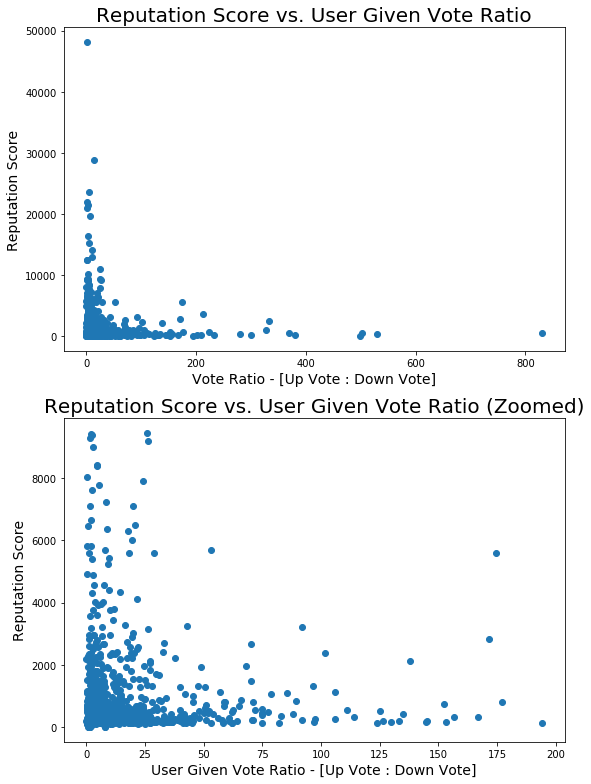

In [83]:
less200Ratio = q3_result_df["RatioUpToDown"] <= 200
less200Table = q3_result_df[less200Ratio]

less10000Rep = less200Table["Reputation"] <= 10000
less10000RepTable = less200Table[less20000Rep]

fig2 = plt.figure(figsize = (8.5, 11))

scatterXall = q3_result_df["RatioUpToDown"].values
scatterYall = q3_result_df["Reputation"].values

subP = fig2.add_subplot(2, 1, 1)
subP.scatter(scatterXall, scatterYall)
subP.set_xlabel("Vote Ratio - [Up Vote : Down Vote]", fontsize = 14)
subP.set_ylabel("Reputation Score", fontsize = 14)
subP.set_title("Reputation Score vs. User Given Vote Ratio", fontsize = 20)

subP2 = fig2.add_subplot(2, 1, 2)
subP2.scatter(less10000RepTable["RatioUpToDown"].values, 
             less10000RepTable["Reputation"].values)
subP2.set_xlabel("User Given Vote Ratio - [Up Vote : Down Vote]", fontsize = 14)
subP2.set_ylabel("Reputation Score", fontsize = 14)
subP2.set_title("Reputation Score vs. User Given Vote Ratio (Zoomed)", fontsize = 20)

fig2.tight_layout()
fig2.savefig("figures/q3_scatter_plot.png")
fig2.savefig("figures/q3_scatter_plot.pdf")

In [82]:
q3Pearson = pearsonr(scatterXall, scatterYall)
print("Correlation:", round(q3Pearson[0], 5), ", P-Value:", round(q3Pearson[1], 5))

Correlation: -0.04303 , P-Value: 0.1879
